<a href="https://colab.research.google.com/github/Venu2791/Deep-Vision/blob/master/Assignment%207/Assignment_7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Problem Statement:**

Build the ENAS architecture and run 100 epochs for the same.

In [1]:
from keras import backend as K
import time
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline
np.random.seed(2017) 
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.layers import Activation, Flatten, Dense, Dropout
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils

Using TensorFlow backend.


**Loading and Pre-Processing the Data:**

Number of classes : 10
Training set size : 50K
Test set size : 10K
Image resolution : 32x32


In [2]:
from keras.datasets import cifar10
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
num_train, img_channels, img_rows, img_cols =  train_features.shape
num_test, _, _, _ =  test_features.shape
num_classes = len(np.unique(train_labels))

170500096/170498071 [==============================] - 11s 0us/step


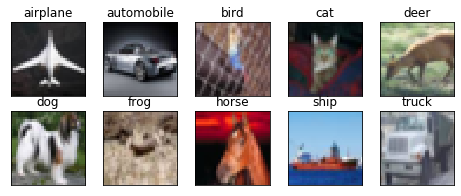

In [3]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(train_labels[:]==i)[0]
    features_idx = train_features[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = features_idx[img_num]
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()

**Plot Model history:**

This function plots the loss and accuracy for both train and validation datasets. The values for the fucntion are the history returned from the fit_generator fucntion. 

In [0]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

##Test Accuracy:
With the trained model, we do the predictions for the test dataset using predict function. We then compute the accuracy.

Accuracy= # of correct predictions/number of samples.

In [0]:
def accuracy(test_x, test_y, model):
    result = model.predict(test_x)
    predicted_class = np.argmax(result, axis=1)
    true_class = np.argmax(test_y, axis=1)
    num_correct = np.sum(predicted_class == true_class) 
    accuracy = float(num_correct)/result.shape[0]
    return (accuracy * 100)

**Pre-processing:**</br>
Convert the image to float.</br>
Standardising the train and test data set by dividing it by 255.</br>
Convert the labels to one hot encoding.</br>

In [0]:
train_features = train_features.astype('float32')/255
test_features = test_features.astype('float32')/255
# convert class labels to binary class labels
train_labels = np_utils.to_categorical(train_labels, num_classes)
test_labels = np_utils.to_categorical(test_labels, num_classes)

In [0]:
#Model
from keras.layers.convolutional import Conv2D,SeparableConv2D,DepthwiseConv2D
from keras.layers.pooling import MaxPooling2D,GlobalAveragePooling2D
from keras.models import Model
from keras.layers import Input,add, Activation,Add,Lambda
from keras.layers.merge import concatenate
from keras.layers.normalization import BatchNormalization
from keras.utils import plot_model
import tensorflow as tf


**Model Architecture:**

We have defined the model in 3 blocks: </br>

Block 1 with vanilla 3X3 and spatially separable Convolutions.</br>
Block2 consists depthwise convolution and grouped convolutions.</br>
Block 3 consists of dialated convolution, after this we use few convolution layers and GAP before softmax.

In [0]:
def get_model(x,sep=False,kernel_size=3,units=32):
  if sep:
     return Activation('relu')(
      BatchNormalization()(
      SeparableConv2D(units, (kernel_size,kernel_size), padding = 'same', use_bias = False)(x)))
  else:
      return Activation('relu')(
      BatchNormalization()(
      Conv2D(units, (kernel_size,kernel_size), padding = 'same', use_bias = False)(x)))   

def add_skip(layers = []):
  return Activation('relu')(Add()(layers))
  
def reshape(x, block_size):
    return tf.nn.space_to_depth(x, block_size)


In [9]:
input_img= Input(shape=(32,32,3))
conv_1=get_model(input_img, True, 5, 16)
conv_2=get_model(conv_1,False,5,16)
conv_3=get_model(conv_2,False,5,16)
skip_1=add_skip([conv_1,conv_3])
conv_4=get_model(skip_1,True,5,16)
add_2=add_skip([conv_4,conv_1])
maxpool_1=MaxPooling2D()(add_2)

conv_1_block=Lambda(reshape,arguments = {'block_size' : 2})(conv_1)
conv_2_block=Lambda(reshape,arguments = {'block_size' : 2})(conv_2)
conv_3_block=Lambda(reshape,arguments = {'block_size' : 2})(conv_3)
conv_4_block=Lambda(reshape,arguments = {'block_size' : 2})(conv_4)

conv_5=get_model(maxpool_1,True,3,16)
conv_5_pointwise=get_model(conv_5,False,1,64)
add_3=add_skip([conv_4_block,conv_5_pointwise])
conv_6=get_model(add_3,False,5,64)
add_4=add_skip([conv_3_block,conv_4_block,conv_5_pointwise,conv_6])
conv_7=get_model(add_4,True,3,64)
add_5=add_skip([conv_1_block,conv_3_block,conv_4_block,conv_5_pointwise,conv_7])
conv_8=get_model(add_5,True,5,64)
add_6=add_skip([conv_7,conv_8,conv_5_pointwise,conv_4_block])
maxpool_2=MaxPooling2D()(add_6)
maxppol_2_pointwise=get_model(maxpool_2,False,1,256)

conv_1_block_2=Lambda(reshape,arguments = {'block_size' : 2})(conv_1_block)
conv_2_block_2=Lambda(reshape,arguments = {'block_size' : 2})(conv_2_block)
conv_3_block_2=Lambda(reshape,arguments = {'block_size' : 2})(conv_3_block)
conv_4_block_2=Lambda(reshape,arguments = {'block_size' : 2})(conv_4_block)
conv_5_block=Lambda(reshape,arguments = {'block_size' : 2})(conv_5)
conv_6_block=Lambda(reshape,arguments = {'block_size' : 2})(conv_6)
conv_7_block=Lambda(reshape,arguments = {'block_size' : 2})(conv_7)
conv_5_blockpointwise_2=get_model(conv_5_block,False,1,256)

add_7=add_skip([maxppol_2_pointwise,conv_6_block])
conv_9=get_model(add_7,False,5,256)
add_8=add_skip([conv_9,conv_4_block_2,conv_2_block_2,conv_1_block_2])
conv_10=get_model(add_8,True,5,256)
add_9=add_skip([conv_10,conv_9,conv_7_block,conv_2_block_2,conv_5_blockpointwise_2])
conv_11=get_model(add_9,False,3,256)
add_10=add_skip([conv_11,conv_3_block_2,conv_7_block,conv_5_blockpointwise_2,conv_10,conv_4_block_2])
conv_12=get_model(add_10,True,5,256)
add_11=add_skip([conv_12,conv_7_block,conv_10,conv_4_block_2])
pointwise=get_model(add_11,False,1,10)
out1=Conv2D(10,(7,7),activation="relu")(pointwise)
out2 = GlobalAveragePooling2D()(out1)
output=Activation("softmax")(out2)

model = Model(inputs=input_img, outputs=output)

#plot_model(model, show_shapes=True,rankdir='TB',dpi=96)'''

In [10]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
separable_conv2d_1 (SeparableCo (None, 32, 32, 16)   123         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 32, 32, 16)   64          separable_conv2d_1[0][0]         
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 32, 32, 16)   0           batch_normalization_1[0][0]      
____________________________________________________________________________________________

##Training the given model:

In the below code, we use DataGenerator objects to train the model in batches (batch_size=128) for 100 epochs.
We plot the accuracy and losses on the training and test sets after each epoch.
We normalize the image and use horizontal flip



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., validation_data=(array([[[..., verbose=1, steps_per_epoch=390, epochs=100)`
  del sys.path[0]




Epoch 1/100


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:724: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


390/390 [==============================] - 28s 71ms/step - loss: 1.3071 - acc: 0.5311 - val_loss: 1.7545 - val_acc: 0.4615
Epoch 2/100
390/390 [==============================] - 20s 51ms/step - loss: 0.9092 - acc: 0.6790 - val_loss: 1.8876 - val_acc: 0.4451
Epoch 3/100
390/390 [==============================] - 20s 51ms/step - loss: 0.7543 - acc: 0.7351 - val_loss: 1.4034 - val_acc: 0.5527
Epoch 4/100
390/390 [==============================] - 20s 52ms/step - loss: 0.6556 - acc: 0.7718 - val_loss: 1.2749 - val_acc: 0.5973
Epoch 5/100
390/390 [==============================] - 20s 51ms/step - loss: 0.5783 - acc: 0.7987 - val_loss: 0.7933 - val_acc: 0.7217
Epoch 6/100
390/390 [==============================] - 20s 51ms/step - loss: 0.5169 - acc: 0.8201 - val_loss: 1.2557 - val_acc: 0.6252
Epoch 7/100
390/390 [==============================] - 20s 50ms/step - loss: 0.4553 - acc: 0.8416 - val_loss: 0.9256 - val_acc: 0.6985
Epoch 8/100
390/390 [==============================] - 20s 52ms/ste

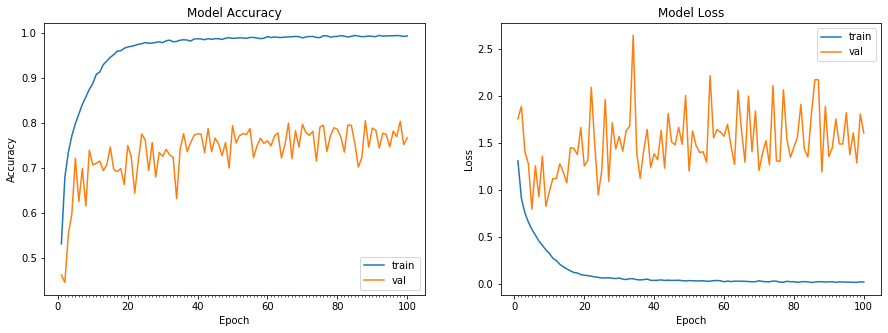

Accuracy on test data is: 76.74


In [11]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(featurewise_center=True,featurewise_std_normalization=True,zoom_range=0.0, 
                             horizontal_flip=True)


# train the model
start = time.time()
# Train the model
model_info = model.fit_generator(datagen.flow(train_features, train_labels, batch_size = 128),
                                 samples_per_epoch = train_features.shape[0], nb_epoch = 100, 
                                 validation_data = (test_features, test_labels), verbose=1)
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_info)
# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(test_features, test_labels, model))